

<p style='text-align: ;'><span style="color: green; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Severstal: Steel Defect Detection</span></p>


 Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. To help make production of steel more efficient, this model will help identify defects.



<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/14241/logos/thumb76_76.png?t=2019-06-17-15-52-14" width="700px">


<p style='text-align: ;'><span style="color: green; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">What is Xception model?</span></p>

Xception is a convolutional neural network that is 71 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database . The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.


<img src="https://gblobscdn.gitbook.com/assets%2F-LRrOFNeUGLZef_2NLZ0%2F-LeEDJgZ_Xj2uTEbaYKT%2F-LeEHZndr-UWea8jfQP8%2Fxception1.jpg?alt=media&token=d2a19b1a-1b5b-410d-90a5-7a5a993fe026" width="800px">






<p style='text-align: ;'><span style="color: green; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Description</span></p>

In this competition you will be predicting the location and type of defects found in steel manufacturing. Images are named with a unique ImageId. You must segment and classify the defects in the test set.

Each image may have no defects, a defect of a single class, or defects of multiple classes. For each image you must segment defects of each class (ClassId = [1, 2, 3, 4]).


<p style='text-align: ;'><span style="color: green; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Files</span></p>

* train_images/ - folder of training images
* test_images/ - folder of test images (you are segmenting and classifying these images)
* train.csv - training annotations which provide segments for defects (ClassId = [1, 2, 3, 4])
* sample_submission.csv - a sample submission file in the correct format; note, each ImageId 4 rows, one for each of the 4 defect classes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import warnings
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.nasnet import NASNetLarge, NASNetMobile
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K
from tensorflow.keras.applications.xception import Xception, preprocess_input
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
# print(os.listdir('../input/severstal-steel-defect-detection'))
from typeguard import typechecked
from typing import Optional

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [4]:
df.shape

(7095, 3)

In [5]:
df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [6]:
# import pandas_profiling as pp
# pp.ProfileReport(df)

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

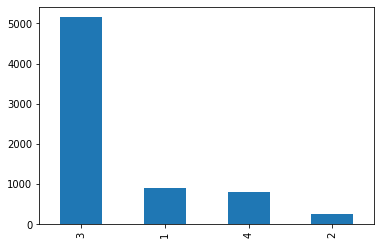

In [7]:
df["ClassId"].value_counts().plot(kind = 'bar')
df["ClassId"].value_counts()

In [8]:
df.shape

(7095, 3)

In [9]:
l1=[]
l2=[] 
for img,ClassId,EncodedPixels in tqdm(df.values):
    image=cv2.imread("train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)


100%|████████████████████████████████████████████████████████████| 7095/7095 [00:36<00:00, 194.56it/s]


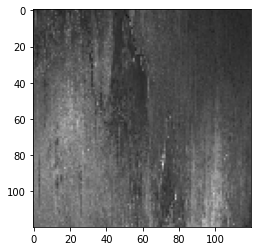

In [10]:
i = 3
plt.imshow(l1[i])


In [11]:
# from tensorflow.python.client import device_lib 
# print(device_lib.list_local_devices())

In [12]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = to_categorical(y)

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)
print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (5676, 120, 120, 3)
x_test shape: (1419, 120, 120, 3)
y_train shape: (5676, 4)
y_test shape: (1419, 4)


In [14]:
base_model = tf.keras.applications.Xception(input_shape=(120,120,3),include_top=False,weights="imagenet")

In [15]:
# Freezing Layers

for layer in base_model.layers[:-5]:
    layer.trainable=False


In [16]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [17]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [18]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image
# plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png')

In [19]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [20]:
# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [21]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [22]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [23]:
%time
history = model.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test),batch_size=128,verbose=1,callbacks=[lrd,mcp,es])

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/15
45/45 [==============================] - 21s 234ms/step - loss: 0.7782 - accuracy: 0.8635 - precision: 0.7640 - recall: 0.6572 - auc: 0.9118 - val_loss: 0.5430 - val_accuracy: 0.8943 - val_precision: 0.8119 - val_recall: 0.7512 - val_auc: 0.9482 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 9s 192ms/step - loss: 0.4679 - accuracy: 0.9041 - precision: 0.8249 - recall: 0.7826 - auc: 0.9600 - val_loss: 0.5293 - val_accuracy: 0.8943 - val_precision: 0.7927 - val_recall: 0.7815 - val_auc: 0.9550 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 9s 192ms/step - loss: 0.3854 - accuracy: 0.9183 - precision: 0.8493 - recall: 0.8184 - auc: 0.9718 - val_loss: 0.4620 - val_accuracy: 0.9112 - val_precision: 0.8270 - val_recall: 0.8154 - val_auc: 0.9645 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 9s 193ms/step - loss: 0.3193 - accuracy: 0.9321 - precision: 0.8738 - recall: 0.8515 - auc: 0.9803 - 

In [24]:
keras_file ="mdl2.h5"
keras.models.save_model(model,keras_file)

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\suman\AppData\Local\Temp\tmpt46wjr0j\assets


In [25]:
cfg = model.get_config()

In [26]:
model.save('modelx')

INFO:tensorflow:Assets written to: modelx\assets


In [30]:
model.save_weights('w.h5')

In [50]:
import pickle
model_json = model.to_json()
# json_object = json.dumps(model_json)
with open("model_arch.json", "wb") as json_file:
    pickle.dump(model_json, json_file)

In [51]:
model_config = pickle.load(open("model_arch.json", "rb"))

In [52]:
from tensorflow.keras.models import model_from_json
model3 = model_from_json(model_config)

In [53]:
model3.load_weights('w.h5')

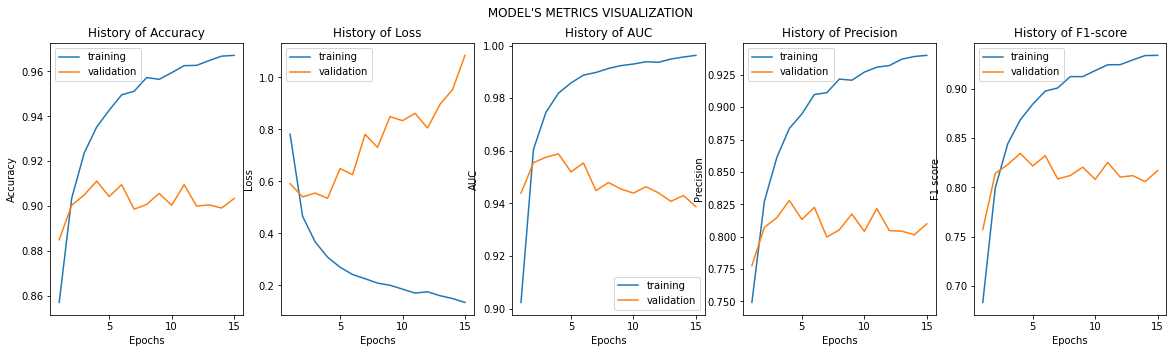

In [24]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [41]:
Evaluate = model.evaluate(X_test, y_test)

In [42]:
# Evaluate

array([[3.18232030e-01, 1.59941125e-03, 6.79635406e-01, 5.33165294e-04],
       [3.23853344e-09, 8.09896583e-14, 1.00000000e+00, 4.04316438e-08],
       [1.56069019e-10, 2.89052746e-16, 1.00000000e+00, 2.55544002e-12],
       ...,
       [9.81963515e-01, 1.85164788e-06, 1.80345662e-02, 1.11734426e-08],
       [1.32550524e-11, 8.37544908e-16, 1.00000000e+00, 3.28657694e-14],
       [3.39273475e-02, 1.65091231e-04, 9.64527547e-01, 1.37996522e-03]],
      dtype=float32)

In [26]:
# do it from here

In [27]:
model.save('steel_defect_detector')

INFO:tensorflow:Assets written to: steel_defect_detector\assets


In [28]:
# prediction = model.predict(X_test)

In [29]:
import numpy as np

In [30]:
l3 = []
for img in tqdm(os.listdir('test_images')):
    image=cv2.imread("test_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l3.append(image)


100%|██████████████████████████████████████████████████████████████████████████| 5506/5506 [00:38<00:00, 142.38it/s]


In [31]:
l3 = np.array(l3)
l3 = l3 / 255

In [32]:
pred = np.argmax(model.predict(l3), axis = 1) + 1

In [33]:
from collections import Counter
count = Counter(pred)
count

Counter({3: 4506, 2: 272, 1: 328, 4: 400})

In [34]:
data = {}
for i, j in enumerate(tqdm(os.listdir('test_images'))):
    data[j] = pred[i]

100%|██████████████████████████████████████████████████████████████████████| 5506/5506 [00:00<00:00, 1380219.81it/s]


In [35]:
data

{'0000f269f.jpg': 3,
 '000ccc2ac.jpg': 2,
 '002451917.jpg': 3,
 '003c5da97.jpg': 3,
 '0042e163f.jpg': 3,
 '004f40c73.jpg': 3,
 '00513039a.jpg': 3,
 '006f39c41.jpg': 3,
 '008725cbc.jpg': 3,
 '0098ca44e.jpg': 3,
 '00a0b7730.jpg': 1,
 '00a0f9949.jpg': 3,
 '00b000b81.jpg': 3,
 '00b7fb703.jpg': 3,
 '00bbcd9af.jpg': 4,
 '00d72c660.jpg': 3,
 '00df5b714.jpg': 3,
 '00f3799a7.jpg': 4,
 '0108ce457.jpg': 3,
 '0109b68ec.jpg': 4,
 '010ec96b4.jpg': 3,
 '011a7e2a9.jpg': 3,
 '0126f74ef.jpg': 3,
 '012754bbb.jpg': 4,
 '01588ee42.jpg': 3,
 '015be539e.jpg': 1,
 '017796c88.jpg': 4,
 '017bd7ce3.jpg': 3,
 '018d7b0a1.jpg': 3,
 '019258298.jpg': 3,
 '0197bb47e.jpg': 3,
 '01b17e176.jpg': 1,
 '01b2163b7.jpg': 3,
 '01b47d973.jpg': 3,
 '01b50837f.jpg': 4,
 '01cc31534.jpg': 4,
 '01d3e8fcb.jpg': 3,
 '01d49cd47.jpg': 3,
 '01db22c17.jpg': 3,
 '01e640f20.jpg': 3,
 '020ffb2d3.jpg': 4,
 '021656fe0.jpg': 3,
 '02217a5cc.jpg': 3,
 '0224561d0.jpg': 3,
 '0241cf678.jpg': 2,
 '0246ad619.jpg': 3,
 '02538bec6.jpg': 3,
 '02662fd2f.j

In [27]:
df_submission = pd.read_csv('sample_submission.csv')
print(df_submission.shape)
df_submission.head()

(5506, 3)


,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [28]:
df_submission.to_csv("submission.csv", index=False)
df_submission

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0
...,...,...,...
5501,ffc9a6187.jpg,1 409600,0
5502,ffdb60677.jpg,1 409600,0
5503,ffe6e2da6.jpg,1 409600,0
5504,fff4fd9bb.jpg,1 409600,0


![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)